In [ ]:
import pandas as pd
df = pd.read_excel('/content/nifty_MV.xlsx')
df.head(2)

,Unnamed: 0,EIM IS Equity,AXSB IS Equity,BJFIN IS Equity,SBILIFE IS Equity,RELIANCE IS Equity,ITC IS Equity,MM IS Equity,SBIN IS Equity,HNDL IS Equity,...,HDFCLIFE IS Equity,DIVI IS Equity,UTCEM IS Equity,UPLL IS Equity,TECHM IS Equity,BJAUT IS Equity,BRIT IS Equity,GRASIM IS Equity,TATACONS IS Equity,NIFTY Index
0,Dates,PX_LAST,PX_LAST,PX_LAST,PX_LAST,PX_LAST,PX_LAST,PX_LAST,PX_LAST,PX_LAST,...,PX_LAST,PX_LAST,PX_LAST,PX_LAST,PX_LAST,PX_LAST,PX_LAST,PX_LAST,PX_LAST,PX_LAST
1,2021-01-01 00:00:00,2542.7,623.8,887.05,895.4,1810.66,213.85,732.45,279.4,238.35,...,678.4,3849.05,5290.8,469.3,977.95,3481.25,3567.8,933.4,601.5,14018.5


In [ ]:
import numpy as np

# Load the Excel file again, skipping the first row with extra headers
df = pd.read_excel('nifty_MV.xlsx', skiprows=1)

# Rename the 'DATE' column to ensure consistency
df.rename(columns={'DATE': 'Dates'}, inplace=True)

# Convert the 'Dates' column to datetime format
df['Dates'] = pd.to_datetime(df['Dates'], format='%Y-%m-%d')

# Set 'Dates' as the index
df.set_index('Dates', inplace=True)

# delete the last two rows of the df
df = df.iloc[:-2]

# Now calculate the log returns for all stock columns
log_returns = np.log(df / df.shift(1))


log_returns.head(2)

,PX_LAST,PX_LAST.1,PX_LAST.2,PX_LAST.3,PX_LAST.4,PX_LAST.5,PX_LAST.6,PX_LAST.7,PX_LAST.8,PX_LAST.9,...,PX_LAST.41,PX_LAST.42,PX_LAST.43,PX_LAST.44,PX_LAST.45,PX_LAST.46,PX_LAST.47,PX_LAST.48,PX_LAST.49,PX_LAST.50
Dates,,,,,,,,,,,,,,,,,,,,,
2021-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-04,0.043482,0.001442,0.003185,0.017711,0.001689,-0.002106,0.022477,0.005888,0.064774,0.07473,...,0.025397,0.003424,0.006856,0.00817,0.024245,0.011765,-0.004185,0.032724,0.004148,0.008128


In [ ]:
# Filing forward missing values
log_returns.fillna(method='ffill', inplace=True)

<ipython-input-24-28422a950c3c>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  log_returns.fillna(method='ffill', inplace=True)


In [ ]:
df.shape

(714, 51)

In [ ]:
# Save log returns to a new Excel file
log_returns.to_excel('log_returns.xlsx')

# Download the saved file
from google.colab import files
files.download('log_returns.xlsx')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the log returns data
log_returns_df = pd.read_excel('log_returns.xlsx')

# Define the sliding window and step size
window_size = 126  # The first 126 days
step_size = 21     # Sliding by 21 rows

# Function to calculate coefficients for the Efficient Frontier
def EFMVcoeff(mu, Sigma):
    """
    Function to calculate coefficients for the Efficient Frontier.

    Parameters:
    mu : numpy array
        Expected returns for each asset.
    Sigma : numpy array
        Covariance matrix for the assets.

    Returns:
    alpha0, alpha1, beta0, beta2, h0, h1 : numpy arrays
        Coefficients needed to plot the Efficient Frontier.
    """
    n = len(mu)           # Number of assets
    ell = np.ones((n, 1)) # Vector of ones (column vector)

    # Calculate intermediate values
    temp1 = np.linalg.solve(Sigma, ell)  # Sigma^(-1) * ell
    temp2 = np.dot(ell.T, temp1)         # ell' * Sigma^(-1) * ell
    h0 = temp1 / temp2                   # Minimum variance portfolio weights

    temp3 = np.linalg.solve(Sigma, mu.reshape(-1, 1))   # Sigma^(-1) * mu
    temp4 = np.dot(ell.T, temp3)         # ell' * Sigma^(-1) * mu
    h1 = temp3 - temp4 * h0              # Tangency portfolio weights

    # Calculate the coefficients
    alpha0 = np.dot(mu.T, h0).item()     # Expected return of the minimum variance portfolio
    alpha1 = np.dot(mu.T, h1).item()     # Expected return of the tangency portfolio
    beta0 = np.dot(np.dot(h0.T, Sigma), h0).item()  # Variance of the minimum variance portfolio
    beta2 = np.dot(np.dot(h1.T, Sigma), h1).item()  # Variance of the tangency portfolio

    return alpha0, alpha1, beta0, beta2, h0, h1

# Define the function to calculate the required portfolios for each window
# Function to calculate the required portfolios for each window# Function to calculate the required portfolios for each window
def calculate_window_portfolios(mu, Sigma, df_next, df_next_nifty):
    # Calculate minimum variance and mean variance portfolios for the current window
    alpha0, alpha1, beta0, beta2, h0, h1 = EFMVcoeff(mu, Sigma)

    # Calculate the sum of the log returns for the next 21 days (cumulative log returns)
    sum_dash = (df_next + 1).sum().values
    # MISTAKE 1 : LOG RETURNS SUM

    # Minimum variance portfolio: t = 0
    W_minVar = np.dot(h0.T, sum_dash)[0]

    # Mean-variance portfolios for t = 1.0 and t = 5.0
    W_meanVar1 = np.dot((h0 + 1.0 * h1).T, sum_dash)[0]

    W_meanVar5 = np.dot((h0 + 5.0 * h1).T, sum_dash)[0]

    # Regularize covariance matrix if it's ill-conditioned (this avoids extreme weights)
    if np.linalg.cond(Sigma) > 1e10:
        Sigma += np.eye(Sigma.shape[0]) * 1e-5  # Add small value to diagonal

    # Debugging checks for unusual portfolio weights
    if W_meanVar1 < -1 or W_meanVar1 > 1:
        print(f"Warning: Unusual portfolio weight at t=1.0: {W_meanVar1}")
    if W_meanVar5 < -1 or W_meanVar5 > 1:
        print(f"Warning: Unusual portfolio weight at t=5.0: {W_meanVar5}")

    # Equal weight portfolio
    n = len(mu)
    equal_weights_portfolio = np.ones(n) / n
    W_equal = np.dot(equal_weights_portfolio, sum_dash)

    # Calculate the sum of log returns for NIFTY over the next 21 days
    nifty_return = np.log(df_next_nifty + 1).sum()

    # Return the calculated portfolio values and NIFTY return
    return (W_minVar, W_meanVar1, W_meanVar5, W_equal, nifty_return)





# Initialize an empty list to store results for all windows
all_windows = []

# Loop through the dataframe in windows
for i in range(0, len(log_returns_df) - window_size, step_size):
    # Extract the current window (first 126 days)
    df_window = log_returns_df.iloc[i:i+window_size, 1:51]

    # Ensure all data is numeric (convert to float and handle non-numeric data)
    df_window = df_window.apply(pd.to_numeric, errors='coerce').fillna(0)

    # Calculate the expected returns (mu) and covariance matrix (Sigma) for the current window
    mu = df_window.mean().values  # Expected returns for the current window
    Sigma = df_window.cov().values  # Covariance matrix for the current window

    # Extract the next 21 days for summing returns (for portfolio calculation)
    df_next = log_returns_df.iloc[i+window_size:i+window_size+step_size, 1:51]
    df_next = df_next.apply(pd.to_numeric, errors='coerce').fillna(0)

    # Extract the next 21 days of NIFTY returns (assuming NIFTY is in the last column)
    df_next_nifty = log_returns_df.iloc[i+window_size:i+window_size+step_size, -1]
    df_next_nifty = df_next_nifty.apply(pd.to_numeric, errors='coerce').fillna(0)

    # Calculate the portfolios for the current window using the calculated mu and Sigma
    portfolios = calculate_window_portfolios(mu, Sigma, df_next, df_next_nifty)

    # Append the results to the list
    all_windows.append(portfolios)

# Convert the results into a DataFrame with the NIFTY return included
windows_df = pd.DataFrame(all_windows, columns=['W_minVar', 'W_meanVar1', 'W_meanVar5', 'W_equal', 'NIFTY_Return'])



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_slsqp_py.py:441: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_slsqp_py.py:495: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_eq = vstack([con['jac'](x, *con['args'])


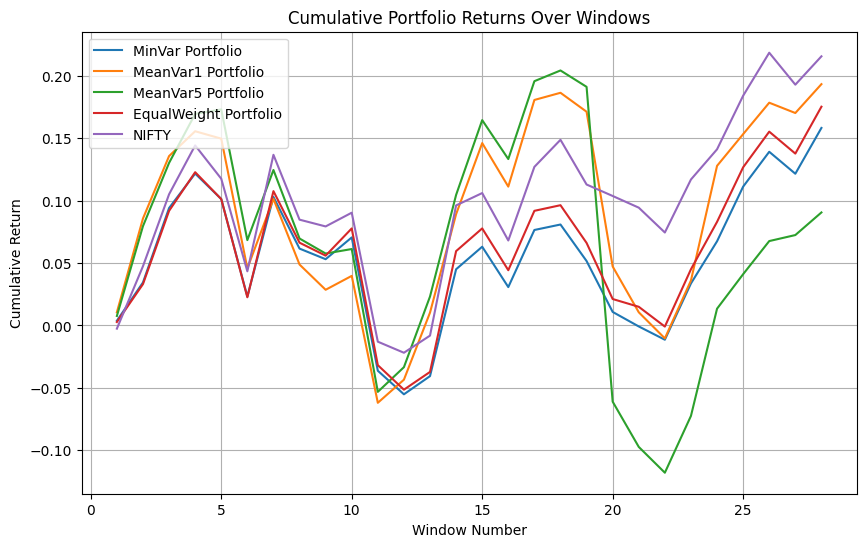

In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Define the objective function for mean-variance optimization
def objective(x, t, mu, Sigma):
    # Ensure mu is a flat array (row vector)
    mu = mu.flatten()
    return -t * np.dot(mu, x) + 0.5 * np.dot(x.T, np.dot(Sigma, x))

# Define the constraint: sum of weights must be 1
def constraint(x):
    return np.sum(x) - 1

# Calculate the mean-variance portfolio weights using optimization with regularization
def calculate_mean_variance_portfolio(mu, Sigma, t):
    # Regularize covariance matrix to avoid overfitting and instability
    Sigma_reg = Sigma + np.eye(Sigma.shape[0]) * 1e-2  # Stronger regularization term

    x0 = np.ones(len(mu)) / len(mu)
    constraints = {'type': 'eq', 'fun': constraint}
    # Restrict weights to avoid extreme portfolios
    bounds = [(0.01, 0.2) for _ in range(len(mu))]

    result = minimize(objective, x0, args=(t, mu, Sigma_reg), bounds=bounds, constraints=constraints)

    if result.success:
        return result.x
    else:
        print(f"Optimization failed for t = {t}.")
        return None

# Function to calculate the minimum variance portfolio
def calculate_min_variance_portfolio(Sigma):
    # Regularize covariance matrix with a stronger term to stabilize the calculation
    Sigma_reg = Sigma + np.eye(Sigma.shape[0]) * 1e-2

    n = Sigma.shape[0]
    ones = np.ones(n)

    Sigma_inv = np.linalg.inv(Sigma_reg)
    num = np.dot(Sigma_inv, ones)
    denom = np.dot(ones.T, num)

    h0 = num / denom
    return h0

# Function to calculate portfolios for each window
def calculate_window_portfolios(mu, Sigma, df_next, df_next_nifty):
    """
    Calculate portfolio weights and cumulative returns for each window.
    """
    # Calculate the sum of log returns for the next 21 days
    sum_dash = np.log(df_next + 1).sum().values

    # Minimum variance portfolio using the corrected formula and regularization
    h0 = calculate_min_variance_portfolio(Sigma)
    W_minVar = np.dot(h0.T, sum_dash)

    # Mean-variance portfolio for t = 1.0 and t = 5.0
    mean_variance_weight_t1 = calculate_mean_variance_portfolio(mu, Sigma, 1.0)
    mean_variance_weight_t5 = calculate_mean_variance_portfolio(mu, Sigma, 5.0)

    W_meanVar1 = np.dot(mean_variance_weight_t1.T, sum_dash) if mean_variance_weight_t1 is not None else np.nan
    W_meanVar2 = np.dot(mean_variance_weight_t5.T, sum_dash) if mean_variance_weight_t5 is not None else np.nan

    # Equal weight portfolio
    n = len(mu)
    equal_weights_portfolio = np.ones(n) / n
    W_equal = np.dot(equal_weights_portfolio, sum_dash)

    # Calculate the sum of log returns for NIFTY over the next 21 days
    nifty_return = np.log(df_next_nifty + 1).sum()

    return (W_minVar, W_meanVar1, W_meanVar2, W_equal, nifty_return)

# Initialize an empty list to store results for all windows
all_windows = []

# Loop through the dataframe in windows
for i in range(0, len(log_returns_df) - window_size, step_size):
    # Extract the current window (first 126 days)
    df_window = log_returns_df.iloc[i:i + window_size, 1:51]

    # Ensure all data is numeric (convert to float and handle non-numeric data)
    df_window = df_window.apply(pd.to_numeric, errors='coerce').fillna(0)

    # Use 50-day moving averages for smoothing expected returns and covariance matrix
    mu_smoothed = df_window.rolling(window=50).mean().iloc[-1].values
    Sigma_smoothed = df_window.rolling(window=50).cov().iloc[-50:].values.reshape(50, 50)

    # Extract the next 21 days for summing returns (for portfolio calculation)
    df_next = log_returns_df.iloc[i + window_size:i + window_size + step_size, 1:51]
    df_next = df_next.apply(pd.to_numeric, errors='coerce').fillna(0)

    # Extract the next 21 days of NIFTY returns (assuming NIFTY is in the last column)
    df_next_nifty = log_returns_df.iloc[i + window_size:i + window_size + step_size, -1]
    df_next_nifty = df_next_nifty.apply(pd.to_numeric, errors='coerce').fillna(0)

    # Calculate the portfolios for the current window using the calculated mu and Sigma
    portfolios = calculate_window_portfolios(mu_smoothed, Sigma_smoothed, df_next, df_next_nifty)

    # Append the results to the list
    all_windows.append(portfolios)

# Convert the results into a DataFrame with the NIFTY return included
windows_df = pd.DataFrame(all_windows, columns=['W_minVar', 'W_meanVar1', 'W_meanVar2', 'W_equal', 'NIFTY_Return'])

# Ensure the cumulative returns are computed correctly using exponentiation
windows_df['Cumulative_MinVar'] = np.exp(windows_df['W_minVar'].cumsum()) - 1
windows_df['Cumulative_MeanVar1'] = np.exp(windows_df['W_meanVar1'].cumsum()) - 1
windows_df['Cumulative_MeanVar2'] = np.exp(windows_df['W_meanVar2'].cumsum()) - 1
windows_df['Cumulative_EqualWeight'] = np.exp(windows_df['W_equal'].cumsum()) - 1
windows_df['NIFTY'] = np.exp(windows_df['NIFTY_Return'].cumsum()) - 1

# Plotting the results
plt.figure(figsize=(10, 6))

# Plot each portfolio cumulative result
plt.plot(windows_df.index + 1, windows_df['Cumulative_MinVar'], label='MinVar Portfolio')
plt.plot(windows_df.index + 1, windows_df['Cumulative_MeanVar1'], label='MeanVar1 Portfolio')
plt.plot(windows_df.index + 1, windows_df['Cumulative_MeanVar2'], label='MeanVar5 Portfolio')
plt.plot(windows_df.index + 1, windows_df['Cumulative_EqualWeight'], label='EqualWeight Portfolio')
plt.plot(windows_df.index + 1, windows_df['NIFTY'], label='NIFTY')

# Labeling the graph
plt.title('Cumulative Portfolio Returns Over Windows')
plt.xlabel('Window Number')
plt.ylabel('Cumulative Return')
plt.legend(loc='upper left')
plt.grid(True)

# Display the plot
plt.show()


In [ ]:
#####

In [ ]:
mew= np.array((1.1,1.2,1.3))
# create a sigma matrix with diagonal entries 0.01,0.05,0.07 and convert it to numpy array
sig = np.diag([0.01, 0.05, 0.07])
sig

array([[0.01, 0.  , 0.  ],
       [0.  , 0.05, 0.  ],
       [0.  , 0.  , 0.07]])

In [ ]:
alphanot, alphaone, betanot, betatwo, hnot, hone = EFMVcoeff(mew, sig)

In [ ]:
hnot,hone

(array([[0.74468085],
        [0.14893617],
        [0.10638298]]),
 array([[-3.61702128],
        [ 1.27659574],
        [ 2.34042553]]))

In [ ]:
hnot+(10*hone)

array([[-35.42553191],
       [ 12.91489362],
       [ 23.5106383 ]])